In [ ]:
from tensorflow import keras 
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout 
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

# Data manipulation
import numpy as np
print('numpy: %s' % np.__version__) 
import sklearn
print('sklearn: %s' % sklearn.__version__)
from sklearn.preprocessing import MinMaxScaler


import os
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__)
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
import graphviz 
print('graphviz: %s' % graphviz.__version__)




Tensorflow/Keras: 2.9.0
numpy: 1.21.6
sklearn: 1.0.2
OpenCV: 4.6.0
matplotlib: 3.2.2
graphviz: 0.10.1


In [ ]:
data = os.path.dirname(r"/content/drive/MyDrive/ROAD_SURFACE/ROAD SURFACE/Road Surface Image/Unpaved Road/Pothole in Rainy/RAW/")

In [ ]:
ImagePaths = []
for image in list(os.listdir(data)):
        ImagePaths=ImagePaths+[data+"/"+image]


In [ ]:
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)
    

data_lowres = np.array(data_lowres, dtype="float") / 255.0


print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (765, 64, 64, 3)


In [ ]:
scaler=MinMaxScaler(feature_range=(-1, 1))

data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)


scaler.fit(data)


data=scaler.transform(data)

data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (765, 64, 64, 3)
Reshaped data:  (9400320, 1)
Shape of the scaled array:  (765, 64, 64, 3)


In [ ]:
def generator(latent_dim):
    model = Sequential(name="Generator")
    

    n_nodes = 8 * 8 * 128
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    

    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              

    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))
    

    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))
    

    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model


latent_dim=100 
gen_model = generator(latent_dim)


gen_model.summary()


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             827392    
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

In [ ]:
def discriminator(in_shape=(64,64,3)):
    model = Sequential(name="Discriminator") 
    

    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    

    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    

    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    

    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'] )
    return model


dis_model = discriminator()


dis_model.summary()


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       3136      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      131200    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 8, 8, 128)      

In [ ]:
def def_gan(generator, discriminator):
    

    discriminator.trainable = False
    

    model = Sequential(name="DCGAN") 
    model.add(generator) 
    model.add(discriminator) 
    

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

gan_model = def_gan(gen_model, dis_model)


gan_model.summary()


Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         3750275   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,155,076
Trainable params: 3,750,275
Non-trainable params: 404,801
_________________________________________________________________


In [ ]:
def real_samples(n, dataset):
    

    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]


    y = np.ones((n, 1))
    return X, y
    
    
def latent_vector(latent_dim, n):
    

    latent_input = np.random.randn(latent_dim * n)
    

    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    

    latent_output = latent_vector(latent_dim, n)
    

    X = generator.predict(latent_output)
    

    y = np.zeros((n, 1))
    return X, y   

In [ ]:

def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    

    x_real, y_real = real_samples(n, dataset)

    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    

    x_fake, y_fake = fake_samples(generator, latent_dim, n)

    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    

    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    plt.plot(real_accuracy , label='Real Accuracy')
    plt.plot(fake_accuracy , label='Fake Accuracy')
    

    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 
   

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100, callbacks=[early_stopping]):
    
    d_list , g_list = [] , []

    half_batch = int(n_batch / 2)
    

    for i in range(n_epochs):
    

        x_real, y_real = real_samples(half_batch, dataset)

        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        

        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    

        x_gan = latent_vector(latent_dim, n_batch)

        y_gan = np.ones((n_batch, 1))
        

        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        d_list.append(discriminator_loss)
        g_list.append(generator_loss)

        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            plt.plot(d_list,label='Discriminator Loss')
            plt.plot(g_list , label='Generator Loss') 
            plt.legend()     
            performance_summary(g_model, d_model, dataset, latent_dim)

1/1 [==============================] - 2s 2s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.436672568321228
Generator Loss:  1.116075873374939
2/2 [==============================] - 6s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  1.0


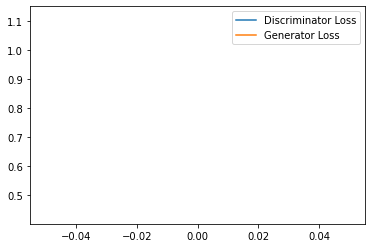

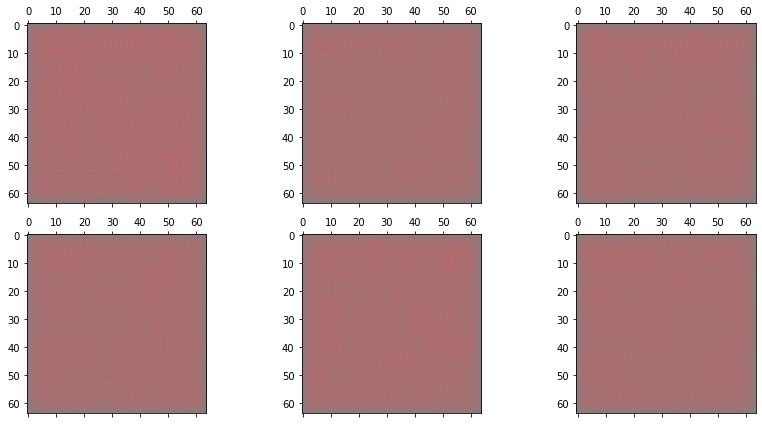

1/1 [==============================] - 2s 2s/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.29218047857284546
Generator Loss:  1.2389205694198608
2/2 [==============================] - 8s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  1.0


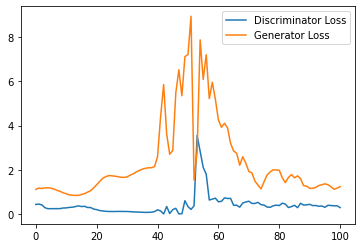

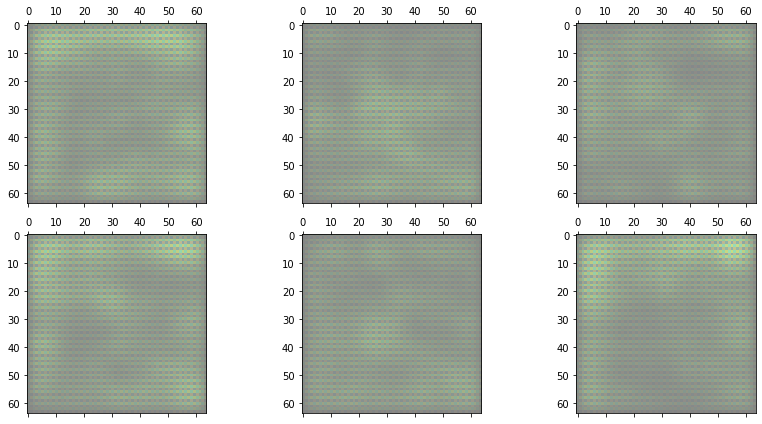

1/1 [==============================] - 2s 2s/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.4088252782821655
Generator Loss:  2.1795544624328613
2/2 [==============================] - 7s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9200000166893005
Discriminator Accuracy on FAKE (generated) images:  0.0


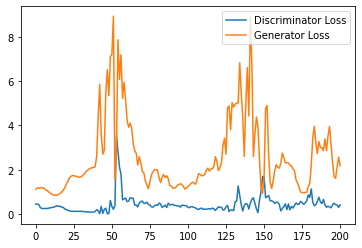

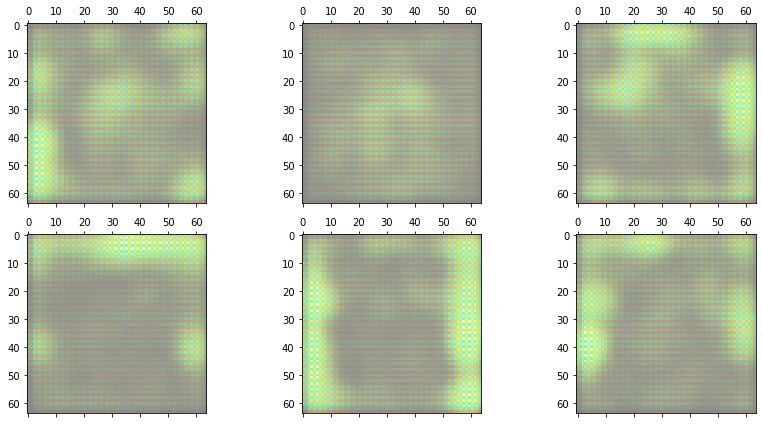

1/1 [==============================] - 2s 2s/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.3953813910484314
Generator Loss:  1.9562863111495972
2/2 [==============================] - 6s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  1.0


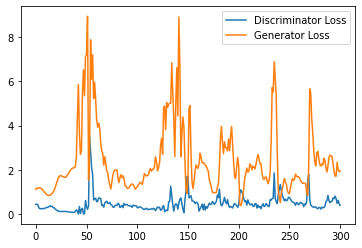

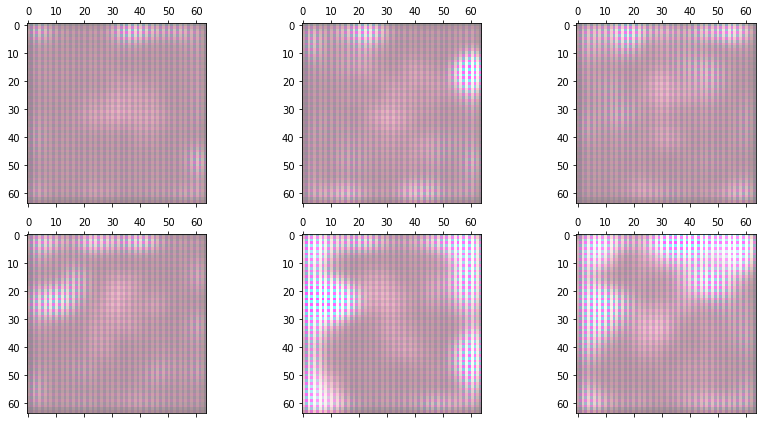

1/1 [==============================] - 2s 2s/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.33528226613998413
Generator Loss:  2.2436351776123047
2/2 [==============================] - 6s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7799999713897705
Discriminator Accuracy on FAKE (generated) images:  1.0


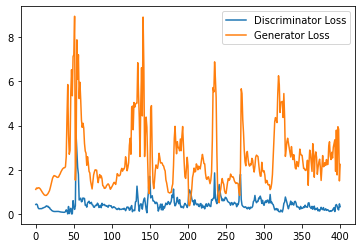

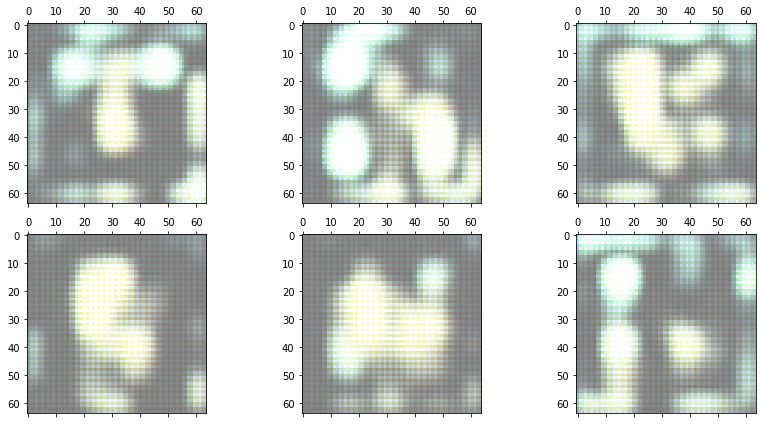

1/1 [==============================] - 2s 2s/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.8226666450500488
Generator Loss:  0.743937611579895
2/2 [==============================] - 7s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.019999999552965164


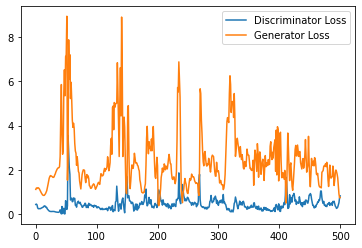

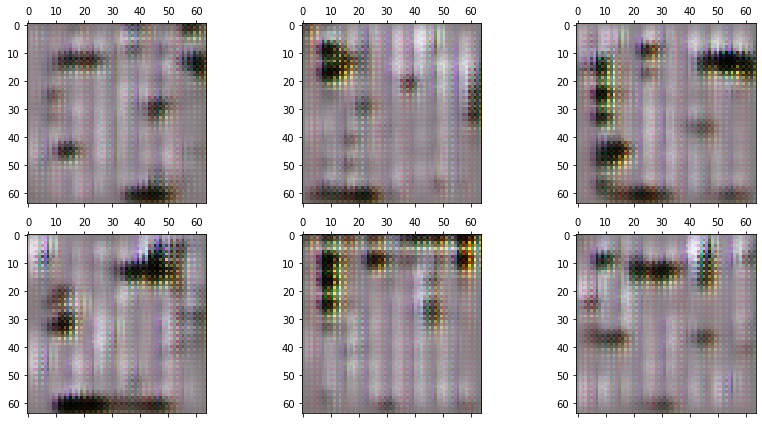

1/1 [==============================] - 3s 3s/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.5694853067398071
Generator Loss:  6.183808326721191
2/2 [==============================] - 7s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  1.0


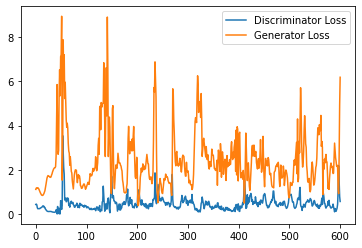

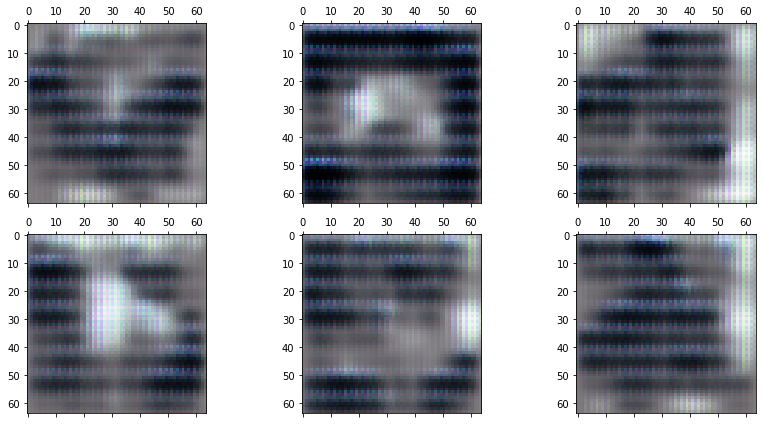

1/1 [==============================] - 2s 2s/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.8222585320472717
Generator Loss:  1.5068684816360474
2/2 [==============================] - 6s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.4399999976158142


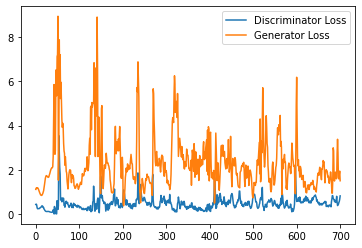

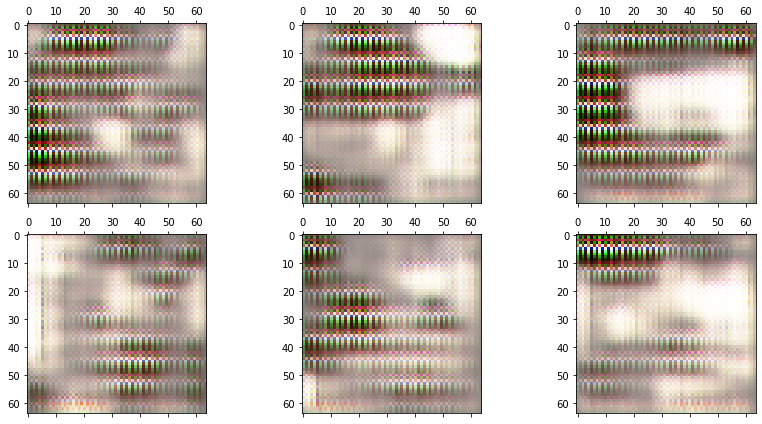

1/1 [==============================] - 2s 2s/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.747771680355072
Generator Loss:  1.4197349548339844
2/2 [==============================] - 7s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


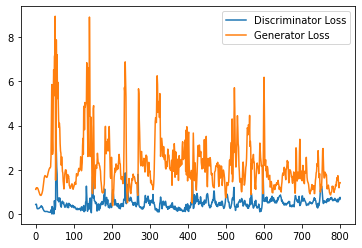

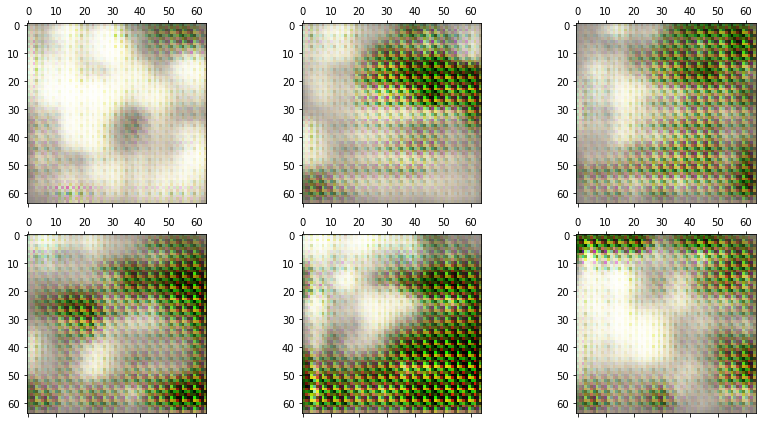

1/1 [==============================] - 2s 2s/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.4047139286994934
Generator Loss:  2.03232479095459
2/2 [==============================] - 6s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


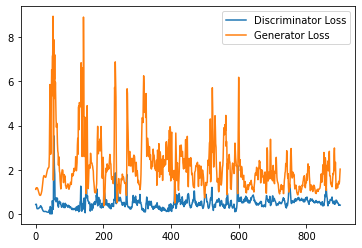

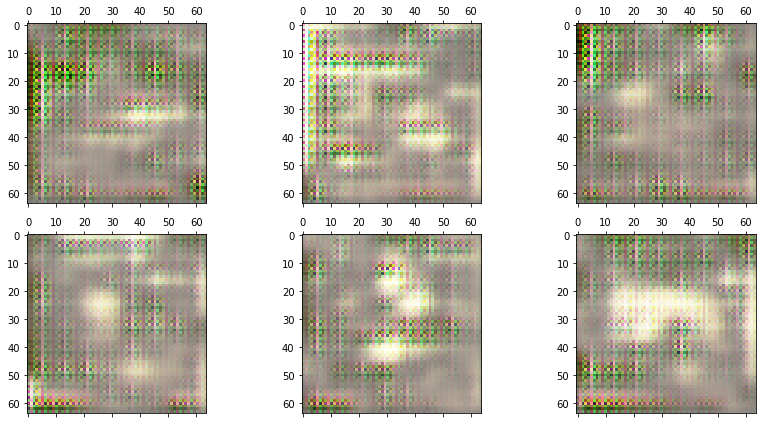

1/1 [==============================] - 2s 2s/step
Epoch number:  1000
*** Training ***
Discriminator Loss  1.1026928424835205
Generator Loss:  2.7085375785827637
2/2 [==============================] - 6s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.3400000035762787


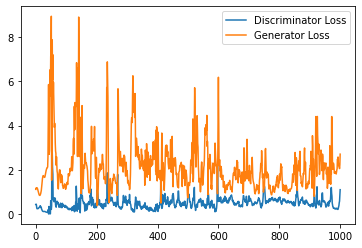

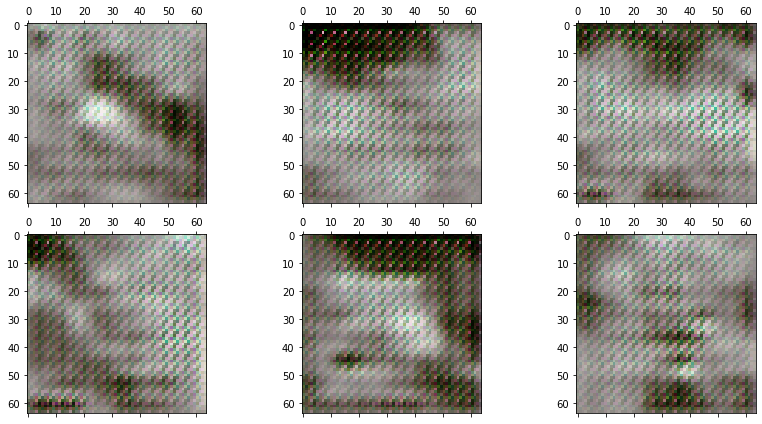

In [ ]:
train(gen_model, dis_model, gan_model, data, latent_dim)